# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Survey Correlations

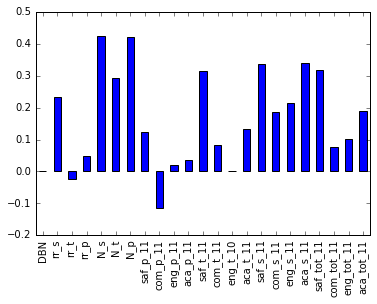

In [10]:
correlations[survey_fields].plot.bar()

It's evident from the above bar plot that N_s, N_p, aca_s_11, and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is interesting to know that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.


## Relation between safety and SAT scores

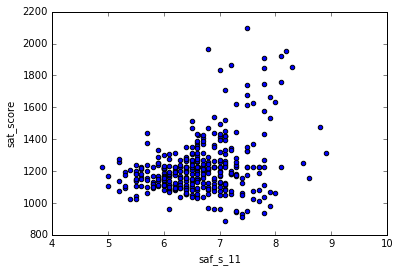

In [11]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

Above scatter plot shows that students achieving higher SAT score tend to come from schools having safety score more than 6.5. There are some schools having higher safety scores but lower SAT scores. The correlation between the SAT score and safety score of school is not that strong.

## Plotting Safety

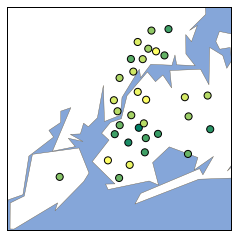

In [12]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

#Plotting NYC's 5 boroughs area lat's and long's into cartesian plots
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

The points on the map with varying color depict the safety scores, green being safest and yellow being with low safety. It seems that Upper Manhattan and Queens show schools with low safety scores, while Brooklyn shows the schools with high safety scores.

## Relation between race and SAT scores

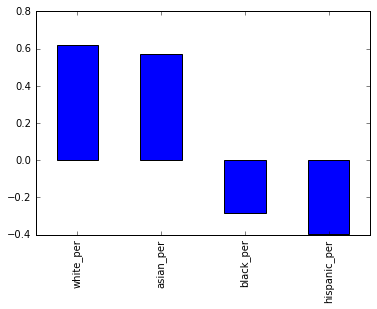

In [13]:
race_per = ['white_per', 'asian_per','black_per','hispanic_per']
correlations[race_per].plot.bar()

It seems that higher SAT scores are achieved by white and asian race group. They have a positive correlation with SAT scores. WHile Black and hispanic race group show negative correlation with SAT scores with Hispanic race group showing maximum negative correlation.

### SAT score vs Schools with Hispanic student percentage

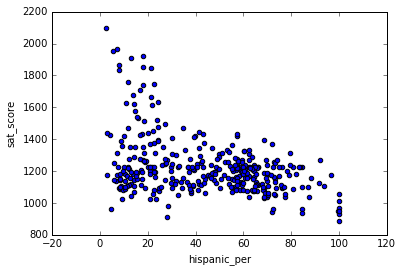

In [14]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

Schools with higher hispanic students show a decrease in average SAT scores achieved by students by that school/year.

### Plotting schools with 95% hispanic percentage students

In [15]:
hispanic_schools_95 = combined['SCHOOL NAME'][combined['hispanic_per']>95]
hispanic_schools_95

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

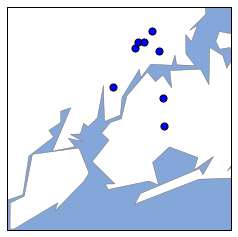

In [16]:
#Extracting coordinates of schools having +95% hispanic student %
lats= list(combined.iloc[hispanic_schools_95.index]['lat'])
lons= list(combined.iloc[hispanic_schools_95.index]['lon'])

#Generating the scatter plot
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.scatter(lons,lats, s=50, zorder=2, latlon=True)
plt.show()

It can be seen from the above graph that majority schools with more than 95% hispanic student population is in Upper Manhattan area.

### Plotting schools with 10% hispanic percentage students

In [17]:
criteria = [i and j for i,j in zip(combined['hispanic_per']<10,combined['sat_score']>1800)]
hispanic_schools_10 = combined['SCHOOL NAME'][criteria]
hispanic_schools_10

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

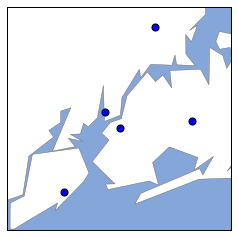

In [18]:
#Extracting coordinates of schools having 10% hispanic student and 1800+ SAT score%
lats= list(combined.iloc[hispanic_schools_10.index]['lat'])
lons= list(combined.iloc[hispanic_schools_10.index]['lon'])

#Generating the scatter plot
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.scatter(lons,lats, s=50, zorder=2, latlon=True)
plt.show()

It's interesting to know that each borough has a school where hispanic student percentage is less than 10% and average SAT score of the school is greater than 1800.

## Relation between gender and SAT scores

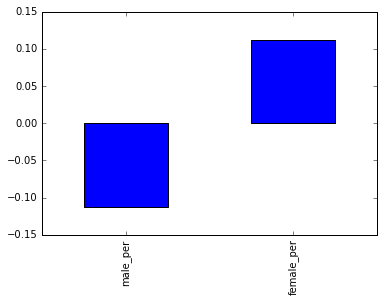

In [19]:
correlations[['male_per','female_per']].plot.bar()

Above plot depicts that there is positive correlation between SAT score and number of female students in a school while it's opposite with male student percentage and SAT score. Neither of the correlation is strong.

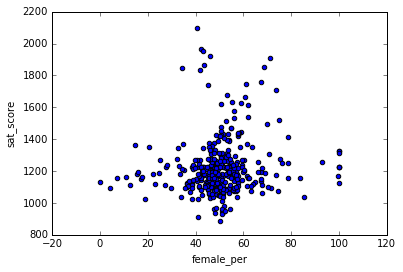

In [31]:
combined.plot.scatter(x='female_per', y='sat_score')

From the above scatter plot we are unable to reach any significant evidence of female percentage driving SAT scores, but the trend suggests that majority of the schools having female percentage between 40-60% have below average SAT scores,which lies in the range of 1000-1400

In [21]:
criteria = [i and j for i,j in zip(combined['female_per']>60,combined['sat_score']>1700)]
female_60_1700 = combined['SCHOOL NAME'][criteria]
female_60_1700

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

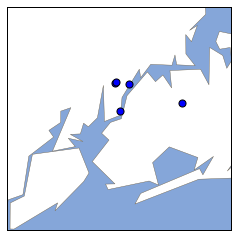

In [22]:
#Extracting coordinates of schools having 60% female students and 1700+ SAT score%
lats= list(combined.iloc[female_60_1700.index]['lat'])
lons= list(combined.iloc[female_60_1700.index]['lon'])

#Generating the scatter plot
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.scatter(lons,lats, s=50, zorder=2, latlon=True)
plt.show()

From the scatter plot above, we can know that majority of schools having more than 60% female students in school and SAT score being more than 1700 are situated in Upper Manhattan Area.

## Relation between AP (Advanced Placement) Scores and SAT scores

In [23]:
ap_per=combined['AP Test Takers ']/combined['total_enrollment']
ap_per.head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
dtype: float64

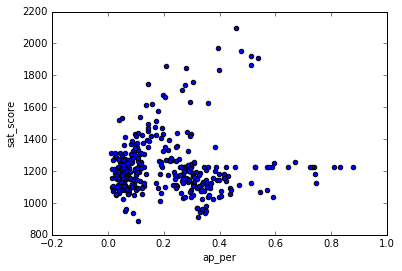

In [24]:
plt.scatter(x=ap_per,y=combined['sat_score'])
plt.xlabel('ap_per')
plt.ylabel('sat_score')


It seems that there is a positivve correlation between AP test takers and SAT scores. There are schools where as AP test takers rises, there is increase in SAT score achieved by the school. While there are some schools having high percentage of AP test takers but having score below 1300.

## Relation between class size and SAT scores

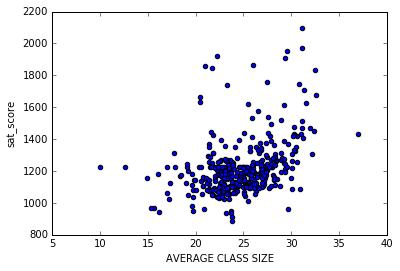

In [43]:
combined.plot.scatter(x='AVERAGE CLASS SIZE',y='sat_score')

Contrarary to belief, as the class size increases there is an increase in SAT score value. The plot shows a positive correlation between average class size and SAT scores.

In [57]:
criteria = [i and j for i,j in zip(combined['AVERAGE CLASS SIZE']>25,combined['sat_score']>1600)]
class_20_1400 = combined['SCHOOL NAME'][criteria]
class_20_1400

4      NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
24           N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
278       LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

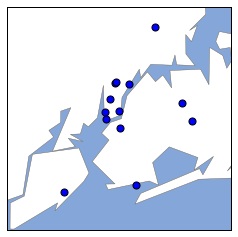

In [58]:
#Extracting coordinates of schools having 60% female students and 1700+ SAT score%
lats= list(combined.iloc[class_20_1400.index]['lat'])
lons= list(combined.iloc[class_20_1400.index]['lon'])

#Generating the scatter plot
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.scatter(lons,lats, s=50, zorder=2, latlon=True)
plt.show()

It is visual from the plot above, schools with more than 25 class size and 1600 SAT score, are situated in Manhattan area.

## Relation between Boroughs and SAT scores

In [41]:
boros = combined.groupby("boro").agg(np.mean)
boros.reset_index(inplace=True)
boros[['boro','AP Test Takers ','sat_score','total_students']]

,boro,AP Test Takers,sat_score,total_students
0,Bronx,96.473842,1157.598203,549.569892
1,Brooklyn,131.645682,1181.364461,751.556604
2,Manhattan,126.135363,1278.331410,633.588889
3,Queens,160.463942,1286.753032,1187.187500
4,Staten Island,228.908654,1382.500000,1847.500000
